# Trotter Simulation 
Here we perfrom Quantum simulation of quantum system using the Trotter-Suzuki formula to decompose the exponential of a sum
of operators. The concepts and methods used in this notebook can be found in "Simulating Hamiltonian Dynamics Using Product Formulas", Omar Al Saeed. 

The most straightforward way of applying the time evolution operator $U(t)$ on some arbitrary initial state $|\phi(0)\rangle $ is to diagonalize the operator $H$ However, the basis of the diagonalized representation is often nontrivial, especially in cases where the Hamiltonian is a sum of non-commuting terms. However, using the Trotter-Suzuki formula we can approximate the multiplication of two non-commmuting operaters in the exponent to:

$$ e^{xAB} = \lim_{n \to 0}(e^{xA/n}e^{xB/n})^n $$
Where A and B are operators. 

The hamiltonian studied in this notbook is:
\begin{equation}H = -\sum_{i,j}J_{i,j}\sigma_i^z \sigma_j^z - h\sum\sigma_j^x  \end{equation}

The $\sigma_z$ terms do commute with each other, but don't commute with the $ \sigma_x $ terms. For the purpose of this notebook, we will take $ A = \sum_{i,j}J_{i,j}\sigma_i^z \sigma_j^z$ and $B = h \sum\sigma_j^x $

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from scipy.linalg import expm
from numpy.linalg import matrix_power

from scipy.integrate import ode

# for analytical exponentiation
from scipy.linalg import expm 
print("done")

done


In [21]:
def trotter_sim(J, h, initial_state, time, trotter_num):
    
    initial_state = np.asarray(initial_state)
    
    N = len(J)
    
    sum_sx = []
    # build h times sum sigma_j^x
    for i in range(N):
        # make a list of N qeye matrices for one qubit
        op_list = []
        for _ in range(N):
            op_list.append(qeye(2))  
        # replace the jth element with sigmax, tensor, then append sum_sx
        op_list[i] = sigmax()
        sum_sx.append(h*tensor(op_list))
        
    B = 0
    for op in sum_sx:
        B -= op
    B = np.asarray(B)
    
    sum_sz_sz = []
    # bild sum J_{i,j} sigma_i^z sigma_j^z, we ignore the case where i = j
    for i in range(N):      
        for j in range(N):
            if i == j:
                continue
            # make a list of N qeye matrices for one qubit
            op_list = []
            for _ in range(N):
                op_list.append(qeye(2))  
            # replace the ith and jth elements with sigma_z, tensor, then append to sum_sz_sz
            op_list[i] = sigmaz()
            op_list[j] = sigmaz()
            sum_sz_sz.append(J[i][j]*tensor(op_list))
            
    A = 0        
    for op in sum_sz_sz:
        A -= op
    A = np.asarray(A)
    
    U = np.matmul(expm(-1j*A*time/trotter_num), expm(-1j*B*time/trotter_num))
    U = matrix_power(U, trotter_num)
    
    return np.matmul(U, initial_state)
    
    
h = 1
J = np.array([[1, 1], [1, 1]])
initial_state = tensor(basis(2, 0), basis(2, 0))

trotter_sim(J, h, initial_state, 5, 5)
    

array([[-0.03728151-0.3958429j ],
       [ 0.27057861-0.12383234j],
       [ 0.27057861-0.12383234j],
       [ 0.80179002+0.14817821j]])

Simulation params:

In [22]:
h = 1
J = np.array([[1, 1], [1, 1]])
initial_state = tensor(basis(2, 0), basis(2, 0))
trotter_num = 100
# define time points
times = np.linspace(0.0, 10, 100)

def construct_hamiltonian(J, h):
    N = len(J)
    
    sum_sx = []
    # build h times sum sigma_j^x
    for i in range(N):
        # make a list of N qeye matrices for one qubit
        op_list = []
        for _ in range(N):
            op_list.append(qeye(2))  
        # replace the jth element with sigmax, tensor, then append sum_sx
        op_list[i] = sigmax()
        sum_sx.append(h*tensor(op_list))
        
    sum_sz_sz = []
    # bild sum J_{i,j} sigma_i^z sigma_j^z, we ignore the case where i = j
    for i in range(N):      
        for j in range(N):
            if i == j:
                continue
            # make a list of N qeye matrices for one qubit
            op_list = []
            for _ in range(N):
                op_list.append(qeye(2))  
            # replace the ith and jth elements with sigma_z, tensor, then append to sum_sz_sz
            op_list[i] = sigmaz()
            op_list[j] = sigmaz()
            sum_sz_sz.append(J[i][j]*tensor(op_list))
    H = 0
    for op in sum_sz_sz:
        H -= op
    for op in sum_sx:
        H -=op
    return H

Perform simulation:

In [23]:
trotter_states = []
for t in times:
    trotter_states.append(trotter_sim(J, h, initial_state, t, trotter_num))

## Numerical Solution

Schrodinger equation states that:
$$ |\phi(t)\rangle = U|\phi (0)\rangle$$
where $ U = e^{-\frac{-iHt}{\hbar}}$

H in this case is not diagonal, becuase the $\sigma_x$ terms are not diagonal. We will use np.expm() to find the state of the system at the same time steps as in the qutip solution.

In [24]:
# we can get H as an array from the qutip object we constructed before by using np.asarray()
H_numerical = np.asarray(construct_hamiltonian(J, h))

initial_state_numerical = np.asarray(initial_state)

numerical_states = []
for t in times:
    U = expm(-1j*H_numerical*t)
    mult = np.matmul(U, initial_state_numerical)
    numerical_states.append(mult)


Find error:

0.023210083396998045


Text(0.5, 1.0, 'Error in using the Trotter formula for the trapped ions hamiltonian against numerical solutio')

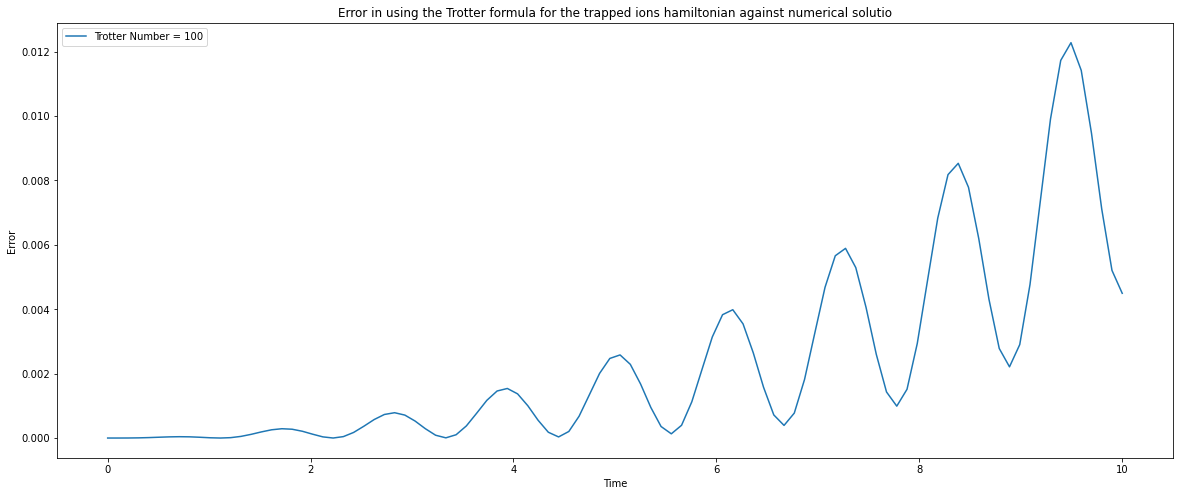

In [25]:
error = []
for i in range(len(times)):
    y = []
    y.append(trotter_states[i][0] - numerical_states[i][0])
    y.append(trotter_states[i][1] - numerical_states[i][1])
    y.append(trotter_states[i][2] - numerical_states[i][2])
    y.append(trotter_states[i][3] - numerical_states[i][3])
    error.append(np.abs(np.vdot(y, y)))
print(np.trapz(error, times))

p = plt.figure(1)
p.set_figwidth(20)
p.set_figheight(8)
p = plt.subplot()
p.plot(times, error) 
p.legend(("Trotter Number = 100",))
p.set_xlabel('Time') 
p.set_ylabel('Error') 
p.set_title("Error in using the Trotter formula for the trapped ions hamiltonian against numerical solutio")

# Analysis
## Trotter Number
Here we investigate how the trotter number affect the error. 

In [32]:
trotter_states_at_diff_steps = []

# produce 10 different values of trotter steps
t_num = 1
trotter_nums = [t_num]
for _ in range(15):
    t_num = t_num * 10
    trotter_nums.append(t_num)
print(trotter_nums)

for trotter_num in trotter_nums:
    trotter_states = []
    for t in times:
        trotter_states.append(trotter_sim(J, h, initial_state, t, trotter_num))
    trotter_states_at_diff_steps.append(trotter_states)
print("done")

[1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000, 100000000000, 1000000000000, 10000000000000, 100000000000000, 1000000000000000]
done


Fine the error curve for each trotter number compared to the numerical solution 

In [33]:
error_at_diff_trotter_number = []
for trotter_states in trotter_states_at_diff_steps:
    error = []
    for i in range(len(times)):
        y = []
        y.append(trotter_states[i][0] - numerical_states[i][0])
        y.append(trotter_states[i][1] - numerical_states[i][1])
        y.append(trotter_states[i][2] - numerical_states[i][2])
        y.append(trotter_states[i][3] - numerical_states[i][3])
        error.append(np.abs(np.vdot(y, y)))
    error_at_diff_trotter_number.append(error)

area_under_error_curve_at_diff_trotter_number  = []
for error in error_at_diff_trotter_number:
    area_under_error_curve_at_diff_trotter_number.append(np.trapz(error, times))
print(area_under_error_curve_at_diff_trotter_number)

[10.377793133151215, 6.842527630947706, 0.023210083396998045, 0.00016683815198575682, 1.661898944378298e-06, 1.6618341078236522e-08, 1.6618339893894194e-10, 1.6618527123483462e-12, 1.812080920313064e-14, 6.519657758590249e-14, 4.187183910688712e-14, 6.331158138162236e-14, 6.281467024069642e-14, 4.0240582976168427e-14, 5.356884994399586e-14, 6.724209591549202e-14]


Text(0.5, 1.0, 'Error at different Trotter numbers')

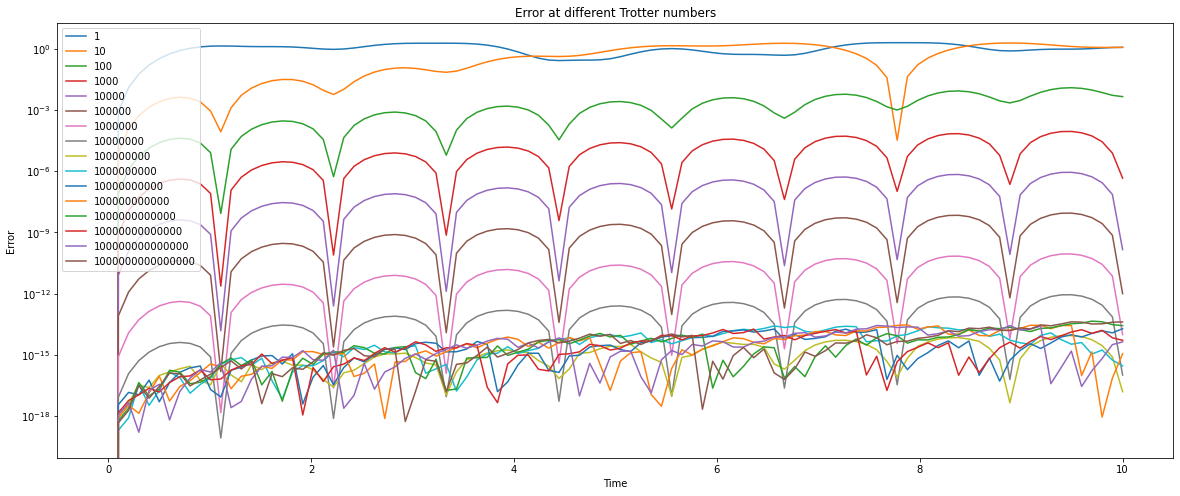

In [34]:
p = plt.figure(1)
p.set_figwidth(20)
p.set_figheight(8)
p = plt.subplot()
for error in error_at_diff_trotter_number:
    p.plot(times, error)
p.legend(trotter_nums)
p.set_yscale('log')
p.set_xlabel('Time') 
p.set_ylabel('Error ') 
p.set_title("Error at different Trotter numbers")

Text(0.5, 1.0, 'Area under error curve at different Trotter numbers')

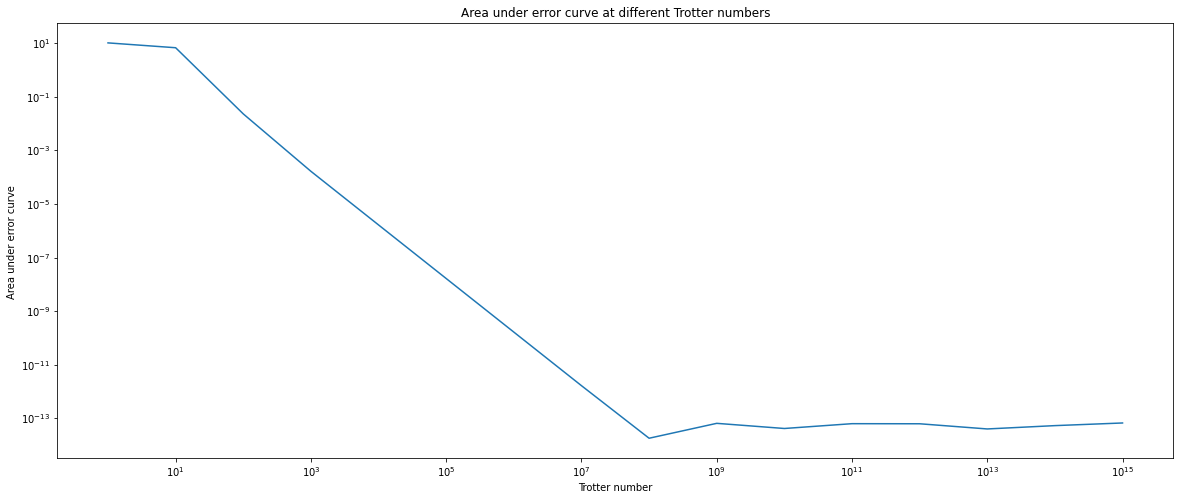

In [31]:
p = plt.figure(1)
p.set_figwidth(20)
p.set_figheight(8)
p = plt.subplot()
p.plot(trotter_nums, area_under_error_curve_at_diff_trotter_number) 
p.set_xscale('log')
p.set_yscale('log')
p.set_xlabel('Trotter number') 
p.set_ylabel('Area under error curve ') 
p.set_title("Area under error curve at different Trotter numbers")

Text(0.5, 1.0, 'Area under error curve Trotter number')

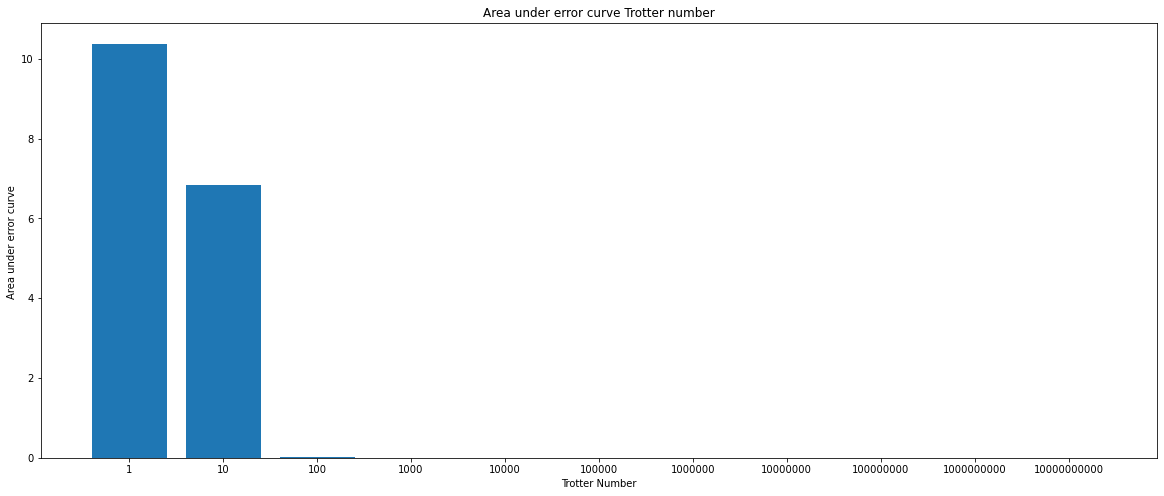

In [120]:
p = plt.figure(1)
p.set_figwidth(20)
p.set_figheight(8)
p = plt.subplot()
p.bar(list(map(str, trotter_nums)) , area_under_error_curve_at_diff_trotter_number) 
p.set_xlabel('Trotter Number') 
p.set_ylabel('Area under error curve ') 
p.set_title("Area under error curve at different Trotter numbers")
